### CT preprocessing code

The code can help dealing with the raw CT data

In [1]:
'''
Author: Feng-Chiao, Lee
Date: 2022-03
Edited:2022-11-30
'''

'\nAuthor: Feng-Chiao, Lee\nDate: 2022-03\nEdited:2022-11-30\n'

In [1]:
import cv2
import numpy as np
np.set_printoptions(threshold = np.inf)
import pydicom
import matplotlib.pyplot as plt
import dicom2nifti
import nibabel as nib
import scipy
import sys
from sklearn import preprocessing
from skimage import exposure
import os
import pandas as pd
from scipy.ndimage import label
from scipy.ndimage.morphology import generate_binary_structure
import SimpleITK as sitk
from pathlib import Path
import skimage.morphology as sm
import glob
from shutil import copy
import pandas as pd
import itk
import itkwidgets
#elastixImageFilter = sitk.ElastixImageFilter()

In [2]:
def sitk2itk(sitk_img, IMAGE_DIMENSION):
    npsitk_img = sitk.GetArrayFromImage(sitk_img)
    itk_img = itk.GetImageFromArray(npsitk_img)
    itk_img.SetOrigin(sitk_img.GetOrigin())
    itk_img.SetSpacing(sitk_img.GetSpacing())
    itk_img.SetDirection(itk.GetMatrixFromArray(np.reshape(np.array(sitk_img.GetDirection()), [IMAGE_DIMENSION]*2)))
    return itk_img
def itk2sitk(itk_img):
    npitk_img = itk.GetArrayFromImage(itk_img)
    sitk_img = sitk.GetImageFromArray(npitk_img, isVector = itk_img.GetNumberOfComponentsPerPixel()>1)
    sitk_img.SetOrigin(tuple(itk_img.GetOrigin()))
    sitk_img.SetSpacing(tuple(itk_img.GetSpacing()))
    sitk_img.SetDirection(itk.GetArrayFromMatrix(itk_img.GetDirection()).flatten())
    return sitk_img

In [3]:
needs_preprocess = glob.glob(r'S:\StrokeAI\CT_Defaced_dataset\[!_]*')
needs_preprocess

['S:\\StrokeAI\\CT_Defaced_dataset\\2396_1611014548',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2820_1451480351',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2445_2294947692',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2786_2941021245',
 'S:\\StrokeAI\\CT_Defaced_dataset\\3106_1796587439',
 'S:\\StrokeAI\\CT_Defaced_dataset\\3124_2236831900',
 'S:\\StrokeAI\\CT_Defaced_dataset\\3012_6559622978',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2651_7108378507',
 'S:\\StrokeAI\\CT_Defaced_dataset\\3112_4872611097',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2529_1385534111',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2723_1516748921',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2702_1697056466',
 'S:\\StrokeAI\\CT_Defaced_dataset\\3015_6087632858',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2791_1103562044',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2913_2149557883',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2237_4562088604',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2279_1783226933',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2854_3247004977',
 'S:\\StrokeAI\\CT_Defaced_d

In [3]:
def CT_preprocess(nif_dat, new_spacing ,level, window, scale, fltsize, Origin):
    """ Given an 3D nifti data, scale into window and level. Scale between
    expects a tuple (new_min, new_max) that determines the new range.The preprocess 
    also do the resampling and registrationof the CT image.
    Works with both 2D and 3D data.
    
    nif_dat: input the data from sitkImage Read
    new_spacing: the voxel size: [voxel[0], voxel[1], voxel[2]]
    level : center of window, window = width of window.
    scale : (min_scale, max_scale) to rescale in-window values to.
    filt_size : the median filter kernal size; Ex:fltsize = 5  = median_filter(5,5,5)
    Origin: The nifti data origin

    """
    
    #input MNI_152 model and do the registration of the CT image
    
    MNI_152 = sitk.ReadImage(r"S:\StrokeAI\Try\mni_icbm152_nlin_asym_09a\mni_icbm152_t1_tal_nlin_asym_09a.nii")
    MNI_152_img = sitk.GetArrayFromImage(MNI_152)
    elastixImageFilter  = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(MNI_152)
    elastixImageFilter.SetMovingImage(nif_dat)
    regisImage = elastixImageFilter.Execute()
#     fixed_image = sitk.ReadImage(r"S:\StrokeAI\Try\co-regis\Jacob_test1_b0.nii.gz")
#     moving_image = nif_dat
#     parameter_object = itk.ParameterObject.New()
#     default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
#     parameter_object.AddParameterMap(default_rigid_parameter_map)
#     regisImage, regis_trans_parameters = itk.elastix_registration_method(
#         fixed_image, moving_image,
#         parameter_object = parameter_object,
#         log_to_console = True)
    
#     # Resampling the CT image into voxel size(1,1,1)
#     size = np.array(regisImage.GetSize())
#     spacing = np.array(regisImage.GetSpacing())
#     new_spacing1 = new_spacing
#     is_label = False
#     new_spacing = np.array(new_spacing1)
#     new_size = size * spacing / new_spacing1
#     new_spacing_refine = size * spacing / new_size
#     new_spacing_refine = [float(s) for s in new_spacing_refine]
#     new_size = [int(s) for s in new_size]

#     resample  = sitk.ResampleImageFilter()
#     resample.SetOutputDirection(regisImage.GetDirection())
#     resample.SetOutputOrigin(regisImage.GetOrigin())
#     resample.SetSize(new_size)
#     resample.SetOutputSpacing(new_spacing_refine)

#     if is_label:
#         resample.SetInterpolator(sitk.sitkNearestNeighbor)
#     else:
#         resample.SetInterpolator(sitk.sitkLinear)
#     newimage = resample.Execute(regisImage)
    
    # denoise the image by 3D median filter
    img = sitk.GetArrayFromImage(regisImage)
    img = scipy.ndimage.median_filter(img, size = (fltsize,fltsize,fltsize))
    
    # Extract the brain
    im_size = img.shape
    re_img = np.zeros(im_size,np.uint8)
    upper = level + window/2.0
    lower = level - window/2.0
    for num in range(im_size[0]):
        img1 = img[num, :, :]
        new_img = img1.copy()        
  #      pos = np.where((new_img >= lower) & (new_img <= upper))
        new_img[new_img > upper] = upper
        new_img[new_img < lower] = lower

        # Delete the Gantry
        if new_img.max() > 0: 
            ref, bi_img = cv2.threshold(img1 ,0,1,cv2.THRESH_BINARY)
            bi_img = np.uint8(bi_img)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
            op = np.zeros(img1.shape,np.uint8)
            pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])
            num1 = np.delete(np.bincount(pixel_label),0)
            label_brain = np.where(num1 == num1.max())[0]+1
            mask = labels == label_brain
            brain_pos = np.where(mask[:,:] == True)
            op[mask] = new_img[brain_pos]
            op.astype(float)
            re_img[num, :, :] = op
        elif new_img.max() == 0:
            op = new_img
            re_img[num, :, :] = op
    re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
    re_img = sitk.GetImageFromArray(re_img)
    re_img.SetSpacing(regisImage.GetSpacing())
    return re_img

In [4]:
def CT_preprocess1(nif_dat, new_spacing ,level, window, scale, fltsize, Origin):
    """ Given an 3D nifti data, scale into window and level. Scale between
    expects a tuple (new_min, new_max) that determines the new range.The preprocess 
    also do the resampling and registrationof the CT image.
    Works with both 2D and 3D data.
    
    nif_dat: input the data from sitkImage Read
    new_spacing: the voxel size: [voxel[0], voxel[1], voxel[2]]
    level : center of window, window = width of window.
    scale : (min_scale, max_scale) to rescale in-window values to.
    filt_size : the median filter kernal size; Ex:fltsize = 5  = median_filter(5,5,5)
    Origin: The nifti data origin

    """
    
    print(nif_dat.GetSpacing())
    # denoise the image by 3D median filter
    img = sitk.GetArrayFromImage(nif_dat)
    img = scipy.ndimage.median_filter(img, size = (fltsize,fltsize,fltsize))
    
    # Extract the brain
    im_size = img.shape
    #print(im_size)
    re_img = np.zeros(im_size,np.uint8)
    upper = level + window/2.0
    lower = level - window/2.0
    for num in range(im_size[0]):
        img1 = img[num, :, :]
        new_img = img1.copy()        
  #      pos = np.where((new_img >= lower) & (new_img <= upper))
        new_img[new_img > upper] = upper
        new_img[new_img < lower] = lower

        # Delete the Gantry
        if new_img.max() > 0: 
            ref, bi_img = cv2.threshold(img1 ,0,1,cv2.THRESH_BINARY)
            bi_img = np.uint8(bi_img)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
            #print(stats)
            op = np.zeros(img1.shape,np.uint8)
            pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])
            num1 = np.delete(np.bincount(pixel_label),0)
            label_brain = np.where(num1 == num1.max())[0]+1
            mask = labels == label_brain
            brain_pos = np.where(mask[:,:] == True)
            op[mask] = new_img[brain_pos]
            op.astype(float)
            re_img[num, :, :] = op
        elif new_img.max() == 0:
            op = new_img
            re_img[num, :, :] = op
    re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
    re_img = sitk.GetImageFromArray(re_img)
    #re_img.SetSpacing(result_img.GetSpacing())
#input MNI_152 model and do the registration of the CT image
    MNI_152 = sitk.ReadImage(r"S:\StrokeAI\Try\mni_icbm152_nlin_asym_09a\mni_icbm152_t1_tal_nlin_asym_09a.nii") 
    print('MNI_152 size ',MNI_152.GetSize())
    print('MNI_152 spacing ',MNI_152.GetSpacing())
    fixed_img = sitk.Cast(MNI_152, sitk.sitkFloat32)
    moving_img = sitk.Cast(re_img, sitk.sitkFloat32)
    
    print('moving_img size ',moving_img.GetSize())
    print('moving_img spacing ',moving_img.GetSpacing())
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img, # Note these are purposefuly reversed!
        moving_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    moving_resampled = sitk.Resample(
        moving_img,       # Note these are purposefuly reversed!
        fixed_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkLinear,  # TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    
    itk_fix = sitk2itk(fixed_img,3)
    itk_mov = sitk2itk(moving_resampled,3)
    #print('itk_fix size ',itk.Size(itk_fix))
    print('itk_fix spacing ',itk_fix.GetSpacing())
    #print('itk_mov size ',itk.Size(itk_mov))
    print('itk_mov spacing ',itk_mov.GetSpacing())
    
    parameter_object = itk.ParameterObject.New()
    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)
    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object,log_to_console = True)
    #result_img = itk2sitk(result_img)
    #print('result_img size ',result_img.GetSize())
    result_img = itk2sitk(result_img)
    print('result_img spacing ',result_img.GetSpacing())
    print('result_img spacing ',result_img.GetSize())

    return result_img

In [5]:
def CT_preprocess2(nif_dat, new_spacing ,level, window, scale, fltsize, Origin):
    """ Given an 3D nifti data, scale into window and level. Scale between
    expects a tuple (new_min, new_max) that determines the new range.The preprocess 
    also do the resampling and registrationof the CT image.
    Works with both 2D and 3D data.
    
    nif_dat: input the data from sitkImage Read
    new_spacing: the voxel size: [voxel[0], voxel[1], voxel[2]]
    level : center of window, window = width of window.
    scale : (min_scale, max_scale) to rescale in-window values to.
    filt_size : the median filter kernal size; Ex:fltsize = 5  = median_filter(5,5,5)
    Origin: The nifti data origin

    """
    #input MNI_152 model and do the registration of the CT image
    MNI_152 = sitk.ReadImage(r"S:\StrokeAI\Try\mni_icbm152_nlin_asym_09a\mni_icbm152_t1_tal_nlin_asym_09a.nii") 
    print('MNI_152 size ',MNI_152.GetSize())
    print('MNI_152 spacing ',MNI_152.GetSpacing())
    fixed_img = sitk.Cast(MNI_152, sitk.sitkFloat32)
    moving_img = sitk.Cast(nif_dat, sitk.sitkFloat32)
    
    print('moving_img size ',moving_img.GetSize())
    print('moving_img spacing ',moving_img.GetSpacing())
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img, # Note these are purposefuly reversed!
        moving_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    moving_resampled = sitk.Resample(
        moving_img,       # Note these are purposefuly reversed!
        fixed_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkLinear,  # TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    
    itk_fix = sitk2itk(fixed_img,3)
    itk_mov = sitk2itk(moving_resampled,3)
    #print('itk_fix size ',itk.Size(itk_fix))
    print('itk_fix spacing ',itk_fix.GetSpacing())
    #print('itk_mov size ',itk.Size(itk_mov))
    print('itk_mov spacing ',itk_mov.GetSpacing())
    
    parameter_object = itk.ParameterObject.New()
    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)
    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object,log_to_console = True)
    #result_img = itk2sitk(result_img)
    #print('result_img size ',result_img.GetSize())
    print('result_img spacing ',result_img.GetSpacing())

    # denoise the image by 3D median filter
    img = itk.GetArrayFromImage(result_img)
    img = scipy.ndimage.median_filter(img, size = (fltsize,fltsize,fltsize))
    
    # Extract the brain
    im_size = img.shape
    print(im_size)
    #print(im_size)
    re_img = np.zeros(im_size,np.uint8)
    upper = level + window/2.0
    lower = level - window/2.0
    for num in range(im_size[0]):
        img1 = img[num, :, :]
        new_img = img1.copy()        
  #      pos = np.where((new_img >= lower) & (new_img <= upper))
        new_img[new_img > upper] = upper
        new_img[new_img < lower] = lower

        # Delete the Gantry
        if new_img.max() > 0: 
            ref, bi_img = cv2.threshold(img1 ,0,1,cv2.THRESH_BINARY)
            bi_img = np.uint8(bi_img)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
            #print(centroids)
            op = np.zeros(img1.shape,np.uint8)
            pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])
            print(pixel_label.shape)
            num1 = np.delete(np.bincount(pixel_label),0)
            label_brain = np.where(num1 == num1.max())[0]+1
            mask = labels == label_brain
           # print(mask)
            brain_pos = np.where(mask[:,:] == True)
            #print(brain_pos)
            op[mask] = new_img[brain_pos]
            op.astype(float)
           # plt.figure(num)
           # plt.imshow(op)
            
            re_img[num, :, :] = op
        elif new_img.max() == 0:
            op = new_img
            re_img[num, :, :] = op
    re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
    re_img = sitk.GetImageFromArray(re_img)
    #re_img.SetSpacing(result_img.GetSpacing())
    print('result size: ', re_img.GetSize())
    print('result spacing: ', re_img.GetSpacing())

    return re_img

In [4]:
def CT_preprocess_final(nif_dat_path, new_spacing ,level, window, scale, fltsize, Origin):
    """ Given an 3D nifti data, scale into window and level. Scale between
    expects a tuple (new_min, new_max) that determines the new range.The preprocess 
    also do the resampling and registrationof the CT image.
    Works with both 2D and 3D data.
    
    nif_dat: input the data from sitkImage Read
    new_spacing: the voxel size: [voxel[0], voxel[1], voxel[2]]
    level : center of window, window = width of window.
    scale : (min_scale, max_scale) to rescale in-window values to.
    filt_size : the median filter kernal size; Ex:fltsize = 5  = median_filter(5,5,5)
    Origin: The nifti data origin

    """
    
    MNI_152 = sitk.ReadImage(r"S:\StrokeAI\Try\mni_icbm152_nlin_asym_09a\mni_icbm152_t1_tal_nlin_asym_09a.nii") 
    nif_dat = sitk.ReadImage(nif_dat_path) 

    fixed_img = sitk.Cast(MNI_152, sitk.sitkFloat32)
    moving_img = sitk.Cast(nif_dat, sitk.sitkFloat32)
    
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img, # Note these are purposefuly reversed!
        moving_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    moving_resampled = sitk.Resample(
        moving_img,       # Note these are purposefuly reversed!
        fixed_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkLinear,  # TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    npmoving = sitk.GetArrayFromImage(moving_resampled)
    plt.figure(1)
    plt.imshow(npmoving[80,:,:],cmap ='gray')
    plt.colorbar()
    itk_fix = sitk2itk(fixed_img,3)
    itk_mov = sitk2itk(moving_resampled,3)
    print(itk.size(itk_mov))
    parameter_object = itk.ParameterObject.New()
    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)
    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object,log_to_console = True)
    result_img = itk2sitk(result_img)
    print(result_img.GetSize())
    print(result_img.GetSize())
    npmoving = sitk.GetArrayFromImage(result_img)
    plt.figure(2)
    plt.imshow(npmoving[80,:,:],cmap ='gray')
    plt.colorbar()
    print(npmoving[80,:,:].shape)
    # denoise the image by 3D median filter
    npmoving = scipy.ndimage.median_filter(npmoving, size = (fltsize,fltsize,fltsize))    
    # Extract the brain
    im_size = npmoving.shape
    print(im_size)
    upper = level + window/2.0
    lower = level - window/2.0
    npmoving[npmoving > upper] = upper
    npmoving[npmoving < lower] = lower
    plt.figure(3)
    plt.imshow(npmoving[80,:,:],cmap ='gray')
    plt.colorbar()
    
    re_img = np.zeros(im_size)
#    upper = level + window/2.0
#   lower = level - window/2.0
    for num in range(im_size[0]):
        img1 = npmoving[num, :, :]
        new_img = img1.copy()        
        new_img[new_img > upper] = upper
        new_img[new_img < lower] = lower

    # Delete the Gantry
        if new_img.max() > 0: 
            ref, bi_img = cv2.threshold(img1 ,0,1,cv2.THRESH_BINARY)
            bi_img = np.uint8(bi_img)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
            op = np.zeros(new_img.shape)
            pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])            
            num1 = np.delete(np.bincount(pixel_label),0)
            label_brain = np.where(num1 == num1.max())[0]+1
            mask = labels == label_brain
            brain_pos = np.where(mask[:,:] == True)
            op[mask] = new_img[brain_pos]
            op.astype(float)
            re_img[num, :, :] = op
        elif new_img.max() == 0:
            op = new_img
            re_img[num, :, :] = op
    re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
    re_img = sitk.GetImageFromArray(re_img)

    print('re_img size: ', re_img.GetSize())
    print('re_img spacing: ', re_img.GetSpacing())
   
    return re_img


In [ ]:
img2 = sitk.GetImageFromArray(img1)
print(img2.GetSpacing())
print(img1.shape)
print(img2.GetSize())

In [ ]:
img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\3237_1713327646\3237_1713327646.nii')
img.GetOrigin()

(189, 233, 197)


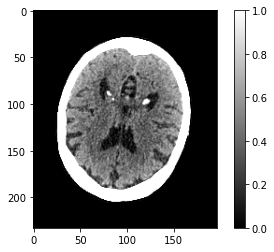

In [42]:
img = sitk.ReadImage(r'S:\StrokeAI\Try\test2.nii')
# tar_img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2456_6229798179\2456_6229798179.nii')
npimg = sitk.GetArrayFromImage(img)
im_size = npimg.shape
print(im_size)
re_img = np.zeros(im_size)
#    upper = level + window/2.0
#   lower = level - window/2.0
for num in range(80,81):#range(im_size[0]):
    #img1 = npimg[num, :, :]
    img1=npimg[80,:,:]
    new_img = img1.copy()        
#     new_img[new_img > upper] = upper
#     new_img[new_img < lower] = lower

# Delete the Gantry
    if new_img.max() > 0: 
        ref, bi_img = cv2.threshold(img1 ,1e-10,1,cv2.THRESH_BINARY)
        bi_img = np.uint8(bi_img) 
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
        op = np.zeros(new_img.shape)
        pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])            
        num1 = np.delete(np.bincount(pixel_label),0)
        label_brain = np.where(num1 == num1.max())[0]+1
        mask = labels == label_brain
        brain_pos = np.where(mask[:,:] == True)
        op[mask] = new_img[brain_pos]
        op.astype(float)
        re_img[num, :, :] = op
    elif new_img.max() == 0:
        op = new_img
        re_img[num, :, :] = op
# re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
plt.imshow(re_img[80,:,:], cmap = "gray")
plt.colorbar()
re_img = sitk.GetImageFromArray(re_img)


(189, 233, 197)


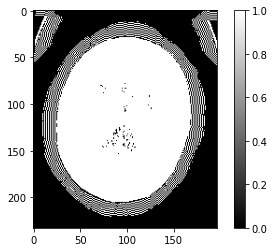

In [27]:
img = sitk.ReadImage(r'S:\StrokeAI\Try\test2.nii')
# tar_img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2456_6229798179\2456_6229798179.nii')
npimg = sitk.GetArrayFromImage(img)
im_size = npimg.shape
print(im_size)
re_img = np.zeros(im_size)
#    upper = level + window/2.0
#   lower = level - window/2.0
for num in range(80,81):#im_size[0]):
    img1 = npimg[num, :, :]
    new_img = img1.copy()        
#     new_img[new_img > upper] = upper
#     new_img[new_img < lower] = lower

# Delete the Gantry
    if new_img.max() > 0: 
        if np.max(img1)<=1e-10:
            low_t=0
        else:
            low_t=1e-10
        ref, bi_img = cv2.threshold(img1 ,low_t,1,cv2.THRESH_BINARY)
        bi_img = np.uint8(bi_img) 
        
        plt.imshow(bi_img, cmap = "gray")
        plt.colorbar()
        
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
        op = np.zeros(new_img.shape)
        pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])            
        num1 = np.delete(np.bincount(pixel_label),0)
        label_brain = np.where(num1 == num1.max())[0]+1
        mask = labels == label_brain
        brain_pos = np.where(mask[:,:] == True)
        op[mask] = new_img[brain_pos]
        op.astype(float)
        re_img[num, :, :] = op
    elif new_img.max() == 0:
        op = new_img
        re_img[num, :, :] = op
# re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
# plt.imshow(re_img[80,:,:], cmap = "gray")
# plt.colorbar()
re_img = sitk.GetImageFromArray(re_img)


(189, 233, 197)
1.0 0.0


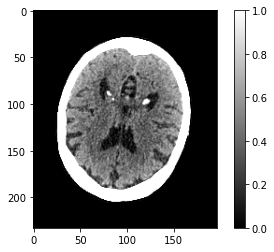

In [35]:
img = sitk.ReadImage(r'S:\StrokeAI\Try\test2.nii')
# tar_img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2456_6229798179\2456_6229798179.nii')
npimg = sitk.GetArrayFromImage(img)
im_size = npimg.shape
print(im_size)
re_img = np.zeros(im_size)
#    upper = level + window/2.0
#   lower = level - window/2.0
num=80
img1=npimg[80,:,:]
new_img = img1.copy()        
# Delete the Gantry
if new_img.max() > 0: 
    print(np.max(new_img),np.min(new_img))
    ref, bi_img = cv2.threshold(img1 ,1e-10,1,cv2.THRESH_BINARY)
    bi_img = np.uint8(bi_img)    
    plt.imshow(bi_img, cmap = "gray")
        
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bi_img)
    op = np.zeros(new_img.shape)
    pixel_label = np.resize(labels, labels.shape[0]*labels.shape[1])       
    
    
    num1 = np.delete(np.bincount(pixel_label),0)
    
    
    label_brain = np.where(num1 == num1.max())[0]+1
    mask = labels == label_brain
    brain_pos = np.where(mask[:,:] == True)
    op[mask] = new_img[brain_pos]
    op.astype(float)
    re_img[num, :, :] = op
elif new_img.max() == 0:
    op = new_img
    re_img[num, :, :] = op
# re_img = (re_img -lower)/ (upper-lower) * (scale[1] - scale[0])
plt.imshow(re_img[80,:,:], cmap = "gray")
plt.colorbar()
re_img = sitk.GetImageFromArray(re_img)


In [35]:
def CheckMiss(img_path, thres_prob):
    testtar_img = sitk.ReadImage(img_path)
    testtar_img = sitk.GetArrayFromImage(testtar_img)
    testtar_img[testtar_img>0] =1
    testtar_img[testtar_img<=0] =0
    numb = []
    for i in range(testtar_img.shape[0]):
        numb.append(sum(sum(testtar_img[i,:,:])))
    for i in range(len(numb)-1):
        short = i
        fast = i+1
        if ((float(abs(numb[i+1]-numb[i]))/numb[i]))>thres_prob:
            return False
            break
    return True


In [ ]:
CheckMiss(r'S:\StrokeAI\CT_Defaced_finish\3003_2080765608\3003_2080765608_output.nii',0.4)

In [ ]:
test_img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2456_6229798179\2456_6229798179.nii')
testtar_img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2721_2963429471\2721_2963429471_output.nii')

In [ ]:
test_img = sitk.GetArrayFromImage(test_img)
testtar_img = sitk.GetArrayFromImage(testtar_img)
test_img[test_img>0] =1
test_img[test_img<=0] =0
testtar_img[testtar_img>0] =1
testtar_img[testtar_img<=0] =0
#print( testtar_img[testtar_img==1].shape)
#if sum(test_img[testtar_img == 1] - testtar_img[testtar_img==1]) != 0:
   # print(False)
#else:
   # print(True)
testtar_img.shape

In [ ]:
numb = []
for i in range(testtar_img.shape[0]):
    numb.append(sum(sum(testtar_img[i,:,:])))
numb2 = []
for i in range(test_img.shape[0]):
    numb2.append(sum(sum(test_img[i,:,:])))

plt.plot(numb)


In [ ]:
total = 0
for i in range(len(numb)-1):
    short = i
    fast = i+1
    if ((float(abs(numb[i+1]-numb[i]))/numb[i]))>0.4:
        print(False)
        print(i+1)


    
#S:\StrokeAI\CT_Defaced_finish\2657_2134840776
        

In [ ]:
plt.imshow(test_img[50,:,:],cmap = 'gray')
plt.colorbar()

In [ ]:
%%time
img2 = CT_preprocess(img, [1.0, 1.0, 1.0] ,40, 80, (0.0,1.0),3,(0,0,0))

In [ ]:
new_img = sitk.GetArrayFromImage(img2)
new_img[new_img > 0] = 1
new_img[new_img <= 0] = 0
plt.imshow(new_img[50,:,:],cmap = 'gray')
plt.colorbar()

In [ ]:
os.chdir(r'S:\StrokeAI\CT_Defaced_finish\2456_6229798179/')
img.SetOrigin(tar_img.GetOrigin())
sitk.WriteImage(tar_img,'2456_6229798179_testoutput.nii')

### Test Code

itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
Wall time: 13.8 s


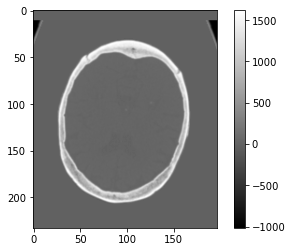

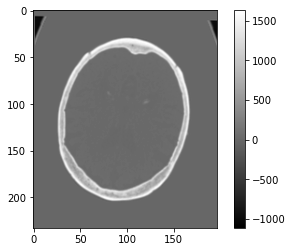

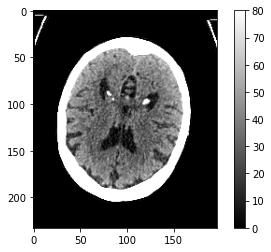

In [29]:
%%time
path = r'S:\StrokeAI\CT_Defaced_dataset\2232_1447512828\2232_1447512828_output.nii'
img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_dataset\2232_1447512828\2232_1447512828_processed.nii')
img2 = CT_preprocess_final(path, [1.0, 1.0, 1.0] ,40, 80, (0.0,1.0),1,(0,0,0))
img2_new = sitk.GetArrayFromImage(img2)


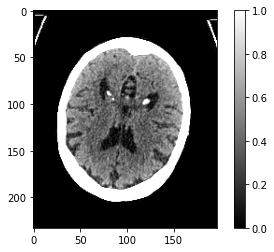

In [147]:
plt.imshow(img2_new[80,:,:], cmap = "gray")
plt.colorbar()

(0.412109375, 0.412109375, 0.5)
MNI_152 size  (197, 233, 189)
MNI_152 spacing  (1.0, 1.0, 1.0)
moving_img size  (512, 512, 320)
moving_img spacing  (1.0, 1.0, 1.0)
itk_fix spacing  itkVectorD3 ([1, 1, 1])
itk_mov spacing  itkVectorD3 ([1, 1, 1])
result_img spacing  (1.0, 1.0, 1.0)
result_img spacing  (197, 233, 189)
Wall time: 10.8 s


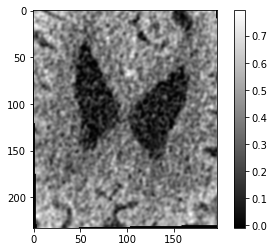

In [50]:
%%time
img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_dataset\2232_1447512828\2232_1447512828_output.nii')
img2 = CT_preprocess1(img, [1.0, 1.0, 1.0] ,40, 80, (0.0,1.0),1,(0,0,0))
img2_new = sitk.GetArrayFromImage(img2)
plt.imshow(img2_new[80,:,:], cmap = "gray")
plt.colorbar()

In [30]:
os.chdir(r'S:\StrokeAI\Try')
sitk.WriteImage(img2, 'test2.nii')

In [ ]:
sav_img = sitk.GetImageFromArray(img2_new)
os.chdir(r'S:\StrokeAI\CT_Defaced_finish\2444_1764450490/')
sitk.WriteImage(sav_img,'2444_1764450490_testoutput.nii')

In [ ]:
plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finish\2880_1088865999\2880_1088865999.nii'))[120,:,:], cmap = "gray")
plt.colorbar()
plt.subplot(122)
img2_new = sitk.GetArrayFromImage(img2)
plt.imshow(img2_new[120,:,:], cmap = "gray")
plt.colorbar()
plt.subplots_adjust(left = 0.125,
                right = 1.4)

In [ ]:
img_new = sitk.GetArrayFromImage(img)
plt.imshow(img_new[80,:,:], cmap = "gray")
plt.colorbar()
plt.savefig('1.png')

In [ ]:
import imageio
images_data = []
#load 10 images

data1 = imageio.imread(img_new[80,:,:])

images_data.append(data1)
images_data.append(img2_new[80,:,:])
imageio.mimwrite('result', images_data, format= '.gif', fps = 1)


In [ ]:
img = sitk.ReadImage(r'S:\StrokeAI\CT_Mask_niinew\2763_9716457986\2763_9716457986_Mask.nii')
img1= sitk.GetArrayFromImage(img)
print(img.GetSize())
img1.shape

In [ ]:
DEBUG = False
def D_g(n,f,b,g):
    if n == 0:
        return f
    if n == 1:           
        return np.min((cv2.dilate(f,b,iterations =1),g),axis =0)
    return D_g(1,D_g(n-1,f,b,g),b,g)
def E_g(n,f,b,g):
    if n == 0:
        return f
    if n == 1:
        return np.max((cv2.erode(f,b,iterations = 1),g),axis = 0)
    return E_g(1,E_g(n-1,f,b,g),b,g)
def R_g_D(f,b,g):
    img = f
    while True:
        new = D_g(1,img,b,g)
        cv2.destroyAllWindows()
        if (new == img).all():
            return img
        img = new
def R_g_E(f,b,g):
    img = f
    while True:
        new = E_g(1,img,b,g)
        cv2.destroyAllWindows()
        if (new == img).all():
            return img
        img = new
def C_R(n,f,b,conn=np.ones((3,3))):
    dilation = cv2.dilate(f,b,iterations = n)
    return R_g_E(dilation,conn,f)
def O_R(n,f,b,conn=np.ones((3,3))):
    erosion = cv2.erode(f,b,iterations = n)
    return R_g_D(erosion,conn,f)

In [ ]:
img1.shape

In [ ]:
img2 = C_R(5,img1,np.ones((13,3)))
plt.subplot(121)
plt.imshow(img1[160,:,:], cmap = "gray")
plt.subplot(122)
plt.imshow(img2[160,:,:], cmap ='gray')

In [ ]:
img1[img1<0] = 0
img1[img1>0] = 1

In [ ]:
kernel = np.ones((5,3),np.uint8)
img1= sitk.GetArrayFromImage(img)
img2 = cv2.morphologyEx(img1,cv2.MORPH_DILATE,kernel,iterations =4)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)

# kernel = np.ones((7,3),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_CLOSE,kernel,iterations =1)
# kernel = np.ones((7,3),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
# kernel = np.ones((9,5),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_CLOSE,kernel,iterations =1)
# kernel = np.ones((11,5),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_CLOSE,kernel,iterations =1)
# kernel = np.ones((15,5),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_CLOSE,kernel,iterations =1)
# kernel = np.ones((1,1),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_ERODE,kernel,iterations =1)

# kernel = np.ones((5,5),np.uint8)
# img2 = cv2.morphologyEx(img1,cv2.MORPH_DILATE,kernel,iterations =1)
# kernel = np.ones((3,1),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_ERODE,kernel,iterations =1)
# kernel = np.ones((7,7),np.uint8)
# img2 = cv2.morphologyEx(img1,cv2.MORPH_DILATE,kernel,iterations =1)
# kernel = np.ones((3,1),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_ERODE,kernel,iterations =1)

# kernel = np.ones((9,9),np.uint8)
# img2 = cv2.morphologyEx(img1,cv2.MORPH_DILATE,kernel,iterations =1)
# kernel = np.ones((3,1),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_ERODE,kernel,iterations =1)
# kernel = np.ones((21,11),np.uint8)
# img2 = cv2.morphologyEx(img1,cv2.MORPH_DILATE,kernel,iterations =1)
# kernel = np.ones((7,7),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_ERODE,kernel,iterations =1)
# kernel = np.ones((9,1),np.uint8)
# img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
plt.subplot(121)
plt.imshow(img1[170,:,:], cmap = "gray")
plt.subplot(122)
plt.imshow(img2[170,:,:], cmap ='gray')

In [ ]:
img2 = sitk.GetImageFromArray(img2)
oricor = img.GetOrigin()
oridirection = img.GetDirection()
# print(oricor)
# print(oridirection)
img2.SetOrigin(oricor)
img2.SetDirection(oridirection)

In [ ]:
sitk.WriteImage(img2,'2245_2587046091_Mask_new.nii')

In [ ]:
img = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finsih\2245_2587046091\2245_2587046091_output.nii')
ori = sitk.ReadImage(r'S:\StrokeAI\CT_Defaced_finsih\2245_2587046091\2245_2587046091.nii')

In [ ]:
oricor = ori.GetOrigin()
oridirection = ori.GetDirection()
print(oricor)
print(oridirection)

In [ ]:
img.SetOrigin(oricor)
#img.SetDirection(oridirection)
print(img.GetOrigin())
print(img.GetDirection())

In [ ]:
sitk.WriteImage(img,'2515_1041691996_output_reset.nii')

In [ ]:
va1 = sitk.GetArrayFromImage(img)
va2 = sitk.GetArrayFromImage(ori)

In [ ]:
va1[170,257,257]-va2[170,257,257]



In [ ]:
def coRegis(fixed_img, moving_img):
    # Generate a centering transform based on the images
    fixed_img = sitk.Cast(fixed_img, sitk.sitkFloat32)
    moving_img = sitk.Cast(moving_img, sitk.sitkFloat32)
    initial_transform = sitk.CenteredTransformInitializer(
        moving_img, # Note these are purposefuly reversed!
        fixed_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    fixed_resampled = sitk.Resample(
        fixed_img,       # Note these are purposefuly reversed!
        moving_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkLinear,  # TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    elastixImageFilter1  = sitk.ElastixImageFilter()
    elastixImageFilter1.SetFixedImage(fixed_resampled)
    elastixImageFilter1.SetMovingImage(moving_img)
    elastixImageFilter1.SetParameterMap("rigid")
    regisImage =elastixImageFilter1.Execute()
    return regisImage

In [ ]:
img = coRegis(ori,img)

In [ ]:
sitk.WriteImage(img,'2245_2587046091_output_regist.nii')

In [ ]:
img2 = CT_preprocess(img, [1.0, 1.0, 1.0] ,40, 80, (0.0,1.0),3,(0,0,0))

In [ ]:
# img2 = sitk.GetArrayFromImage(img2)
plt.imshow(img2[20,:,:], cmap = "gray")
plt.colorbar()

In [ ]:
count = 0
imgindex =[]
imgsze = []
goal_dir = r'S:\StrokeAI\CT_Mask_niinew'
for name in glob.glob(r"S:\StrokeAI\CT_Mask_niinew/*"):
    count+=1
#     if count < 826:
#         continue
    pat_name = os.path.split(name)[-1]
    print(f'============{count}=============')
    pat_folder = os.path.join(goal_dir,os.path.split(name)[-1])
    print(pat_folder)
    os.chdir(pat_folder)
    path = os.path.abspath(os.getcwd())
    for root, dirs,files in os.walk(path):
        for file in files:
            print(file)
            imgindex.append(count)
            img = sitk.ReadImage(os.path.join(root,file))
            print(img.GetSize()[2])
            imgsze.append(img.GetSize()[2])
            if img.GetSize()[2] < 100:
                kernel = np.ones((5,3),np.uint8)
                img1 =sitk.GetArrayFromImage(img)
                img1 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =1)
                img_dil = sitk.GetImageFromArray(img1)
#                 img_dil.SetOrigin(img.GetOrigin())
# #                 img_dil.SetDirection(img.GetDirection())
                sitk.WriteImage(img_dil,f'{pat_name}_maskCorrected.nii')
                print(os.listdir(root))
            elif img.GetSize()[2] > 100 & img.GetSize()[2] < 200:
                kernel = np.ones((5,3),np.uint8)
                img2 = sitk.GetArrayFromImage(img)
                img2 = cv2.morphologyEx(img2,cv2.MORPH_DILATE,kernel,iterations =2)
                img_dil = sitk.GetImageFromArray(img2)
#                 img_dil.SetOrigin(img.GetOrigin())
# #                 img_dil.SetDirection(img.GetDirection())
                sitk.WriteImage(img_dil,f'{pat_name}_maskCorrected.nii')
                print(os.listdir(root))
            elif img.GetSize()[2] > 200 & img.GetSize()[2] < 600:
                kernel = np.ones((7,3),np.uint8)
                img3 = sitk.GetArrayFromImage(img)
                img3 = cv2.morphologyEx(img3,cv2.MORPH_DILATE,kernel,iterations =15)
                kernel_2 = np.ones((3,7),np.unit8)
                img3 = cv2.morphologyEx(img3,cv2.MORPH_DILATE,kernel_2,iterations =7)
                kernel = np.ones((7,3),np.uint8)
                img3 = cv2.morphologyEx(img3,cv2.MORPH_DILATE,kernel,iterations =15)
                kernel_2 = np.ones((3,7),np.unit8)
                img3 = cv2.morphologyEx(img3,cv2.MORPH_DILATE,kernel_2,iterations =7)
                img_dil = sitk.GetImageFromArray(img3)
#                 img_dil.SetOrigin(img.GetOrigin())
#                 img_dil.SetDirection(img.GetDirection())
                sitk.WriteImage(img_dil,f'{pat_name}_maskCorrected.nii')
                print(os.listdir(root))
            elif img.GetSize()[2] > 600:
                kernel = np.ones((7,3),np.uint8)
                img4 = sitk.GetArrayFromImage(img)
                img4 = cv2.morphologyEx(img4,cv2.MORPH_DILATE,kernel,iterations =7)
                img_dil = sitk.GetImageFromArray(img4)
#                 img_dil.SetOrigin(img.GetOrigin())
#                 img_dil.SetDirection(img.GetDirection())
                sitk.WriteImage(img_dil,f'{pat_name}_maskCorrected.nii')
    print("================================")
print("==========All Task Done==========")

In [ ]:
"""
Copy Data Block

"""
# Copy the origin, mask nifti file in the folder name CT_Defaced_finish
count = 0
mask_dir = r'S:\StrokeAI\CT_Mask_niinew'
filtered_dir = r'S:\StrokeAI\CT_filtered'
goal_dir = r'S:\StrokeAI\CT_Defaced_finish'
for name in glob.glob(r"S:\StrokeAI\CT_Mask_niinew/*"):
    count+=1
    if count < 852:
        continue
    pat_name = os.path.split(name)[-1]
    print(f'============{count}=============')
    save_path = os.path.join(goal_dir,os.path.split(name)[-1])
    print(save_path)
    os.makedirs(save_path,exist_ok = True)
    os.chdir(save_path)
    mask_path = os.path.join(mask_dir,pat_name)
    filtered_path = os.path.join(filtered_dir,pat_name)
    for root, dirs,files in os.walk(mask_path):
        for file in files:
            copyfile = os.path.join(root,file)
            copy(copyfile,save_path)
    for root, dirs,files in os.walk(filtered_path):
        for file in files:
            copyfile = os.path.join(root,file)
            copy(copyfile,save_path)
    copy(r'S:\StrokeAI\Try\Data_Preprocess_Code\DefacingTest\DefaceMask.exe',save_path)
#     output_name = f'{pat_name}_output.nii'
    print(os.listdir(save_path))
    print('==============copied==============')

In [ ]:
count = 0
sor_dir = r'S:\StrokeAI\CT_Defaced_finish'
for name in glob.glob(r"S:\StrokeAI\CT_Defaced_finish/*"):
    count+=1
    if count == 698:
        continue
    pat_name = os.path.split(name)[-1]

    print(f'============{count}=============')
    pat_folder = os.path.join(sor_dir,os.path.split(name)[-1])
    print(pat_name)
    os.chdir(pat_folder)
    ori_img = str(f'{pat_name}.nii')
    mask = str(f'{pat_name}_maskCorrected.nii')
    output =str(f'{pat_name}_output.nii')
    result = os.popen(f"DefaceMask.exe {ori_img} {mask} {output}")
    print(result.read())
    print("=================================")
print('========Defaced-TaskDone=======')

In [5]:
needs_preprocess = sorted(needs_preprocess)
needs_preprocess

['S:\\StrokeAI\\CT_Defaced_dataset\\2224_2564111995',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2225_2564111995',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2226_2061339079',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2227_2339850822',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2228_1836983617',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2230_7063720593',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2231_3082828075',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2232_1447512828',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2233_2700613389',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2234_1406879670',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2235_8257173982',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2236_3156947747',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2237_4562088604',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2238_1688598845',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2239_1854400938',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2240_1854400938',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2241_1117341842',
 'S:\\StrokeAI\\CT_Defaced_dataset\\2242_1908524907',
 'S:\\StrokeAI\\CT_Defaced_d

============0=============
S:\StrokeAI\CT_Defaced_dataset\2224_2564111995
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============1=============
S:\StrokeAI\CT_Defaced_dataset\2225_2564111995
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============2=============
S:\StrokeAI\CT_Defaced_dataset\2226_2061339079
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============3=============
S:\StrokeAI\CT_Defaced_dataset\2227_2339850822
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============4=============
S:\StrokeAI\CT_Defaced_dataset\2228_1836983617
itkSize3 ([197, 233, 189])
(197, 2

elementwise comparison failed; this will raise an error in the future.


============15=============
S:\StrokeAI\CT_Defaced_dataset\2240_1854400938
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============16=============
S:\StrokeAI\CT_Defaced_dataset\2241_1117341842
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============17=============
S:\StrokeAI\CT_Defaced_dataset\2242_1908524907
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============18=============
S:\StrokeAI\CT_Defaced_dataset\2243_7049095170
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============19=============
S:\StrokeAI\CT_Defaced_dataset\2244_1850602403
itkSize3 ([197, 233, 189])
(1

re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============47=============
S:\StrokeAI\CT_Defaced_dataset\2277_2016047528
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============48=============
S:\StrokeAI\CT_Defaced_dataset\2278_6799124093
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============49=============
S:\StrokeAI\CT_Defaced_dataset\2279_1783226933
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============50=============
S:\StrokeAI\CT_Defaced_dataset\2280_2532845350
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============51=============
S:\StrokeAI\C

(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============80=============
S:\StrokeAI\CT_Defaced_dataset\2312_3182352848
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============81=============
S:\StrokeAI\CT_Defaced_dataset\2313_3117974311
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============82=============
S:\StrokeAI\CT_Defaced_dataset\2314_1849362056
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============83=============
S:\StrokeAI\CT_Defaced_dataset\2315_8299985582
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============84===========

itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============112=============
S:\StrokeAI\CT_Defaced_dataset\2348_1224379480
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============113=============
S:\StrokeAI\CT_Defaced_dataset\2349_8011765051
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============114=============
S:\StrokeAI\CT_Defaced_dataset\2350_2505780016
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============115=============
S:\StrokeAI\CT_Defaced_dataset\2351_1480275434
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  

itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============144=============
S:\StrokeAI\CT_Defaced_dataset\2384_2432006578
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============145=============
S:\StrokeAI\CT_Defaced_dataset\2385_2633461759
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============146=============
S:\StrokeAI\CT_Defaced_dataset\2386_1583316811
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  (197, 233, 189)
re_img spacing:  (1.0, 1.0, 1.0)
============147=============
S:\StrokeAI\CT_Defaced_dataset\2387_2633461759
itkSize3 ([197, 233, 189])
(197, 233, 189)
(197, 233, 189)
(233, 197)
(189, 233, 197)
re_img size:  

ValueError: left cannot be >= right

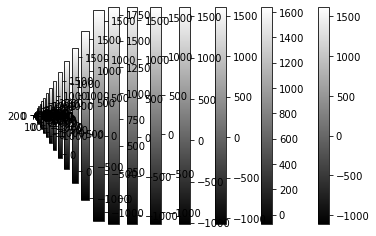

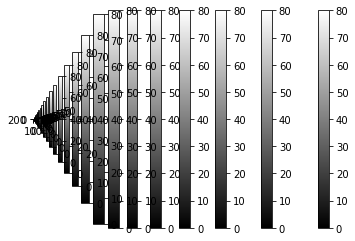

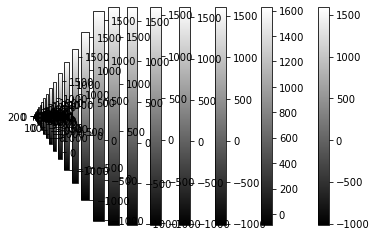

In [7]:
%%time
sor_dir = r'S:\StrokeAI\CT_Defaced_dataset'
incomplete = []
for count, name in enumerate(needs_preprocess):
    pat_name = os.path.split(name)[-1]
    print(f'============{count}=============')
    pat_folder = os.path.join(sor_dir,pat_name)
    if os.path.isfile(os.path.join(pat_folder, f'{pat_name}_processed_final.nii')):
        continue
    else:
        print(pat_folder)
        os.chdir(pat_folder)
        try:
            img2 = CT_preprocess_final(os.path.join(pat_folder,f'{pat_name}_output.nii'), [1.0, 1.0, 1.0] ,40, 80, (0.0,1.0),3,(0,0,0))
            sitk.WriteImage(img2,f'{pat_name}_processed_final.nii')
        except TypeError:
            incomplete.append(pat_name)
    
    print("=================================")
print('========Preprocessed-TaskDone=======')


In [ ]:
incomplete